Diffusion Models - Live Coding Tutorial
url: https://www.youtube.com/watch?v=S_il77Ttrmg

In [5]:
import torch
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [6]:
device = 'cpu'

In [7]:
# Загрузка тренировочного набора
train_dataset = MNIST(root='data/', train=True, transform=None, download=True)

#Загрузка тестового набора данных
test_dataset = MNIST(root='data/', train=False, transform=None, download = True)

#Получение данных из тренировочного набора
train_data = train_dataset.data.float() / 255.0
train_labels = train_dataset.targets

#Получение данных из тестового набора
test_data = test_dataset.data.float() / 255.0
test_labels = test_dataset.targets

In [8]:
class DiffusionModel:
    def __init__(self, start_schedule: float = 0.0001, end_schedule: float = 0.02, timesteps: int = 300):
        self.start_schedule = start_schedule
        self.end_schedule = end_schedule
        self.timesteps = timesteps
        """
        if
            betas = [0.1, 0.2, 0.3, ...]
        then
            alphas = [0.9, 0.8, 0.7, ...]
            alphas_cumprod = [0.9, 0.9 * 0.8, 0.9 * 0.8, * 0.7, ...]
        """
        self.betas = torch.linspace(start_schedule, end_schedule, timesteps)
        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)

    def forward(self, x_0: torch.Tensor, t: torch.Tensor, device: str) -> torch.Tensor:
        """
        Применяет процесс диффузии к тензору `x_0` на заданных временных шагах `t`.

        Аргументы:
        - x_0 (torch.Tensor): Исходный тензор размерности (B, C, H, W).
        - t (torch.Tensor): Тензор временных шагов размерности (B,).

        Возвращает:
        - torch.Tensor: Результат процесса диффузии размерности (B, K, N, C, H, W).

        Функция применяет процесс диффузии к исходному тензору `x_0`, где каждый пиксель на каждом временном шаге
        умножается на соответствующий коэффициент шума из тензора `betas`. Результат процесса диффузии возвращается в виде тензора.

        Пример использования:
        >>> x_0 = torch.randn(2, 3, 32, 32)
        >>> t = torch.tensor([1, 3])
        >>> betas = torch.tensor([0.05, 0.1, 0.15, 0.2, 0.25])
        >>> result = forward_diffusion(x_0, t, betas)
        """
        noise = torch.rand_like(x_0)
        sqrt_alphas_cumprod_t = self.get_index_from_list(self.alphas_cumprod.sqrt(), t, x_0.shape)
        sqrt_one_minus_alphas_cumprod_t = self.get_index_from_list(torch.sqrt(1. - self.alphas_cumprod), t, x_0.shape)

        mean = sqrt_alphas_cumprod_t.to(device) * x_0.to(device)
        variance = sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device)

        return mean + variance, noise.to(device)
    
    @staticmethod
    def get_index_from_list(values, t, x_shape):
        batch_size = t.shape[0]
        """
        pick the values from vals
        according to the indices stored in 't'
        """
        result = values.gather(-1, t.cpu())
        """
        if
        x_shape = (5, 3, 64, 64)
            -> len(x_shape) = 4
            -> len(x_shape) - 1 = 3
        and thus we reshape 'out' to dims
        (batch_size, 1, 1, 1)
        """
        return result.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

In [9]:
IMAGE_SHAPE = (28, 28)

In [10]:
diffusion_model = DiffusionModel()

<Figure size 1500x1500 with 0 Axes>

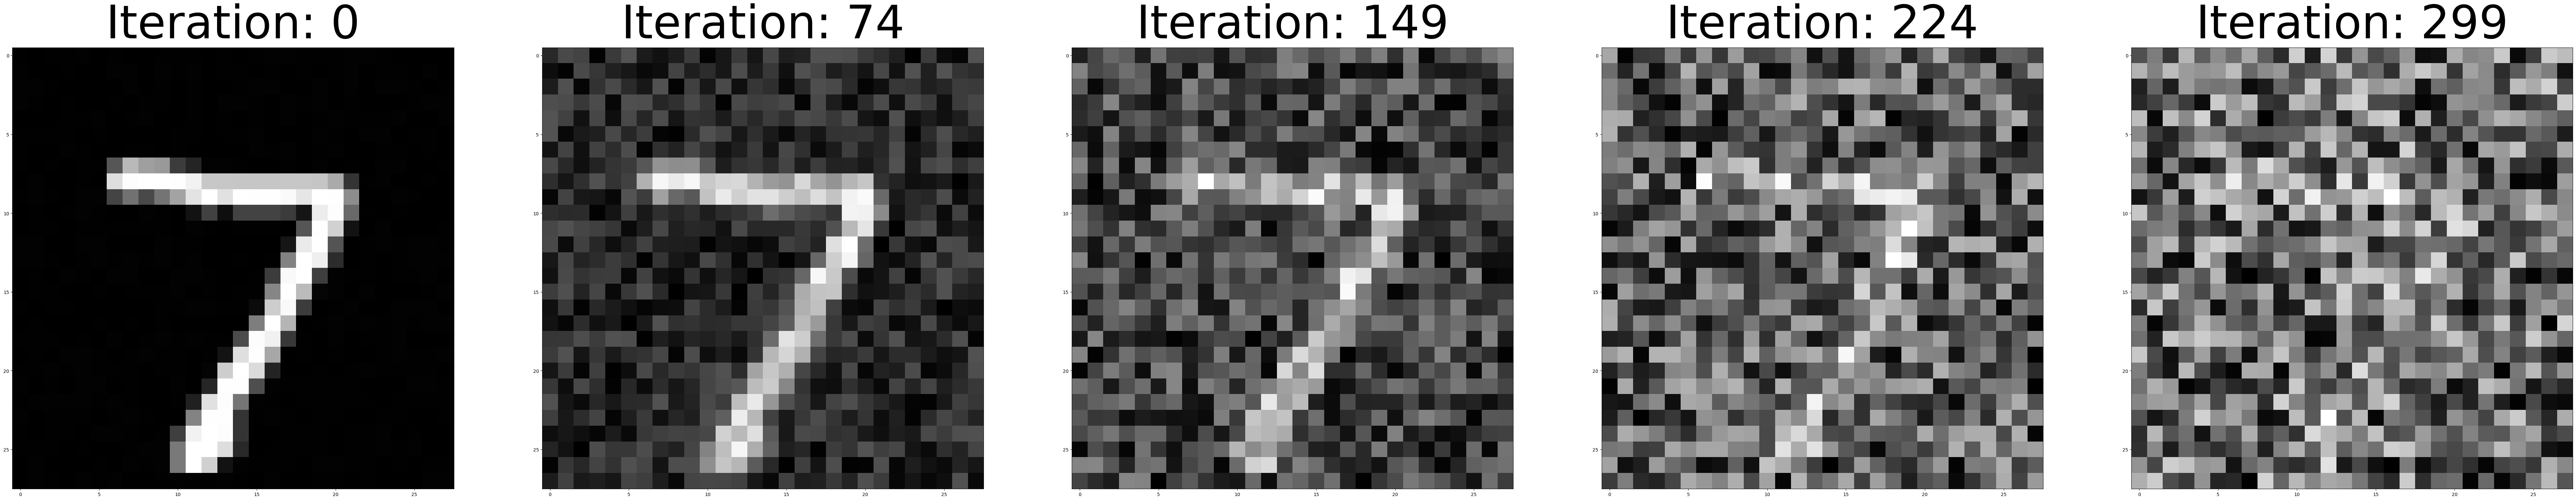

In [14]:
NO_DISPLAY_IMAGES = 5
torch_image_batch = torch.stack([test_data[0]] * NO_DISPLAY_IMAGES)
t = torch.linspace(0, diffusion_model.timesteps -1, NO_DISPLAY_IMAGES).long()
noisy_image_batch, _ = diffusion_model.forward(torch_image_batch, t, device)

plt.figure(figsize=(15,15))
f, ax = plt.subplots(1, NO_DISPLAY_IMAGES, figsize = (100, 100))

for idx, image in enumerate(noisy_image_batch):
    ax[idx].imshow(image, cmap='gray')
    ax[idx].set_title(f"Iteration: {t[idx].item()}", fontsize = 100)
plt.show()